## python -m pip install pip==23.2
^ this version worked for me

## pip install gym-retro

## pip install setuptools==65.5.0 "wheel<0.40.0"

## pip install gym==0.21.0

In [16]:
%pip install gym gym-retro

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Take note of my versions^

In [17]:
# Import retro to play Street Fighter using a ROM
import retro
# Import time to slow down game
import time

In [18]:
# python -m retro.import . # Run this from the roms folder, or where you have your game roms 

In [19]:
# Closes the game environment - important given we can only run one at a time 
# env.close()

# Setup Environment
## What we are going to do! FUNNN

- Observation Preprocess - grayscale (DONE), frame delta, resize the frame so we have less pixels (DONE)
- Filter the action - parameter DONE
- Reward function - set this to the score


In [20]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
# Import environment base class for a wrapper 
from gym import Env 
# Import the space shapes for the environment
from gym.spaces import MultiBinary, Discrete, Box
# Import numpy to calculate frame delta 
import numpy as np
# Import opencv for grayscaling
import cv2
# Import matplotlib for plotting the image
from matplotlib import pyplot as plt

In [22]:
# 1. frame
# 2. preprocess 200x256x3 -> 84x84x1
# 3. change in pixels: current_frame-last_frame

In [23]:
# B, A, _, _, UP, DOWN, LEFT, RIGHT, C, Y, X, Z
# Every possible action for a given step in Street Fighter II
possible_actions = {
    # Idle
    0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # Left
    1 : [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    # Right
    2 : [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    # Up
    3 : [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    # Down
    4 : [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    # Light Kick
    5 : [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # Medium Kick
    6 : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # Hard Kick
    7 : [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    # Light Punch
    8 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    # Medium Punch
    9 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    # Hard Punch
    10 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    # Down Left
    11 : [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
    # Down Right
    12 : [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    # Up Left
    13 : [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
    # Up Right
    14 : [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
}

In [24]:
class StreetFighter(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(
            low=0,
            high=255,
            shape=(84, 84, 3),  # Keep 3 channels for RGB
            dtype=np.uint8
        )
        self.action_space = Discrete(12)  # type of actions that can be taken
        self.game = retro.make(
            game='StreetFighterIISpecialChampionEdition-Genesis',
            use_restricted_actions=retro.Actions.DISCRETE
        )

    def reset(self):
        obs = self.game.reset()
        obs = self.preprocess(obs)
        self.previous_frame = obs
        self.score = 0
        return obs

    def preprocess(self, observation):
        # Resize first to reduce computation
        resized = cv2.resize(observation, (84, 84), interpolation=cv2.INTER_AREA)
        
        # Simple color quantization using bitwise operations
        # Reduce to 3 bits per channel (8 values per channel)
        quantized = resized & 0b11100000
        
        # Optional: Create more distinct colors by increasing contrast
        # This helps make different elements more distinguishable
        quantized = cv2.convertScaleAbs(quantized, alpha=1.2, beta=10)
        
        # Method 1: Simple bitwise quantization
        return quantized

    def step(self, action):
        obs, reward, done, info = self.game.step(action)
        obs = self.preprocess(obs)
        reward = info['score'] - self.score
        self.score = info['score']
        return obs, reward, done, info

    def render(self, *args, **kwargs):
        self.game.render()

    def close(self):
        self.game.close()

In [25]:
# Class based on github
class StreetFighter(Env): # pass in basic env from above to preprocessing
    def __init__(self):
        super().__init__() # inherit from base env
        # Specify action space and observation space 
        self.observation_space = Box(
            low=0,
            high=255,
            shape=(84, 84, 3),  # Keep 3 channels for RGB
            dtype=np.uint8
        )
        self.action_space = Discrete(12) # type of actions that can be taken
        self.health = 144
        self.enemy_health = 144
        self.score = 0
        self.matches_won = 0
        self.continue_timer = 100
        self.enemy_matches_won = 0
        # self.previous_action = np.zeros(12)
        # self.combo_scaler = 1
        # self.last_damage_instance = 0
        # Startup and instance of the game 
        self.game = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis', use_restricted_actions=retro.Actions.DISCRETE) # used to get valid button combos
    
    def reset(self): # restart
        # Return the first frame 
        obs = self.game.reset()
        obs = self.preprocess(obs) 
        self.previous_frame = obs # sets previous frame to current frame
        
        # Create a attribute to hold the score delta 
        self.score = 0 
        return obs
    
    def preprocess(self, observation):
        # Resize first to reduce computation
        resized = cv2.resize(observation, (84, 84), interpolation=cv2.INTER_AREA)
        
        # Simple color quantization using bitwise operations
        # Reduce to 3 bits per channel (8 values per channel)
        quantized = resized & 0b11100000
        
        # Optional: Create more distinct colors by increasing contrast
        # This helps make different elements more distinguishable
        quantized = cv2.convertScaleAbs(quantized, alpha=1.2, beta=10)
        
        # Method 1: Simple bitwise quantization
        return quantized
    
    def reward_function(self, state):
        # Extract variables
        continuetimer = state['continuetimer']
        enemy_matches_won = state['enemy_matches_won']
        enemy_health = state['enemy_health']
        health = state['health']
        matches_won = state['matches_won']
        score = state['score']

        # Initialize reward
        reward = 0

        # Reward for increasing score each frame (scaled down to avoid excessively large rewards)
        reward += score * 0.001  

        enemy_health_diff = self.enemy_health - enemy_health
        health_diff = self.health - health

        # catching edge cases to make sure no reward is being earned outside of a fight (i.e. in between rounds)
        if (self.enemy_health != 0 and state['enemy_health'] == 0 and self.health != 0 and state['health'] == 0) or (enemy_health_diff == 0 and health_diff == 0) or (self.health == 0 and self.enemy_health == 0):
            reward += 0
        else:
            if enemy_health_diff > health_diff:
                reward += ((enemy_health_diff) - (health_diff)) * 10
            else:
                reward += ((enemy_health_diff) - (health_diff))

        # Update previous states to enable frame-by-frame comparison
        self.enemy_health = enemy_health
        self.health = health
        self.matches_won = matches_won
        self.enemy_matches_won = enemy_matches_won
        self.continue_timer = continuetimer
        self.score = score
        # self.last_damage_instance += 1

        return reward
    
    def step(self, action): # how do we process action
        # Take a step 
        obs, reward, done, info = self.game.step(action)
        obs = self.preprocess(obs) 

        self.previous_action = action
        
        # Frame delta 
        frame_delta = obs
        self.previous_frame = obs 
        
        # Reshape the reward function
        reward = self.reward_function(info)

        return frame_delta, reward, done, info
    
    def render(self, *args, **kwargs): # unpack any args and kwargs from stable baseline
        self.game.render()
        
    def close(self):
        self.game.close()

In [26]:
# # Create custom environment 
# class StreetFighter(Env): # pass in basic env from above to preprocessing
#     def __init__(self):
#         super().__init__() # inherit from base env
#         # Specify action space and observation space 
#         self.observation_space = Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8) # grayscaled frame, smaller amt of pixels
#         self.action_space = MultiBinary(12) # type of actions that can be taken
#         # Startup and instance of the game 
#         self.game = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis', use_restricted_actions=retro.Actions.DISCRETE) # used to get valid button combos
    
#     def reset(self): # restart
#         # Return the first frame 
#         obs = self.game.reset()
#         obs = self.preprocess(obs) 
#         self.previous_frame = obs # sets previous frame to current frame
        
#         # Create a attribute to hold the score delta 
#         self.score = 0 
#         return obs
    
#     def preprocess(self, observation): # grayscale, resize
#         # Grayscaling 
#         gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
#         # Resize 
#         resize = cv2.resize(gray, (84,84), interpolation=cv2.INTER_CUBIC)
#         # Add the channels value
#         channels = np.reshape(resize, (84,84,1))
#         return channels 
    
#     def step(self, action): # how do we process action
#         # Take a step 
#         obs, reward, done, info = self.game.step(action)
#         obs = self.preprocess(obs) 
        
#         # Frame delta 
#         frame_delta = obs
#         self.previous_frame = obs 
        
#         # Reshape the reward function
#         reward = info['score'] - self.score 
#         self.score = info['score'] 
        
#         return frame_delta, reward, done, info
    
#     def render(self, *args, **kwargs): # unpack any args and kwargs from stable baseline
#         self.game.render()
        
#     def close(self):
#         self.game.close()

# Hyperparameter Tune

https://pytorch.org/get-started/locally/  <- use this site to download pytorch

In [27]:
%pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
%pip install stable-baselines3[extra]==1.3.0

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
# Importing the optimzation frame - HPO
import optuna
# PPO algo for RL
from stable_baselines3 import PPO, A2C, DQN
# Bring in the eval policy method for metric calculation
from stable_baselines3.common.evaluation import evaluate_policy
# Import the sb3 monitor for logging 
from stable_baselines3.common.monitor import Monitor
# Import the vec wrappers to vectorize and frame stack
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
# Import os to deal with filepaths
import os

In [31]:
LOG_DIR = './logs/'
OPT_DIR = './opt/'

In [32]:
# alternative version to use later to bypass factor 64 error

# PPO optimization parameters
PPO_PARAMS = {
    # 1. Core Parameters
    'n_steps_range': (2048, 4096),            
    # How many steps to run before updating the policy
    # - Larger values (4096): More stable learning, better for complex patterns
    # - Smaller values (2048): Faster updates, but potentially less stable
    # - Must be factor of 64 for efficiency
    
    'gamma_range': (0.95, 0.9999),             
    # Discount factor for future rewards
    # - Higher values (0.995): Values future rewards more (good for long-term strategy)
    # - Lower values (0.95): More focus on immediate rewards
    # - Street Fighter needs high gamma for combo learning
    
    'learning_rate_range': (5e-8, 1e-6),      
    # How big steps to take when updating the policy
    # - Higher values (5e-5): Faster learning but more unstable
    # - Lower values (1e-5): More stable but slower learning
    # - Lowered from original due to training instability
    
    'clip_range_range': (0.1, 0.3),           
    # How much to limit policy updates
    # - Higher values (0.3): Allows bigger policy changes
    # - Lower values (0.1): More conservative updates
    # - Centered around PPO standard of 0.2
    
    'gae_lambda_range': (0.9, 0.98),          
    # Controls advantage estimation smoothing
    # - Higher values (0.98): Better for long-term credit assignment
    # - Lower values (0.9): More focus on immediate advantages
    # - Important for linking moves into combos
    
    # 2. Advanced Parameters
    'ent_coef_range': (1e-8, 1e-3),          
    # Controls exploration vs exploitation
    # - Higher values (1e-3): More random actions/exploration
    # - Lower values (1e-8): More focused on best known moves
    # - Critical for discovering new combat strategies
    
    'vf_coef_range': (0.5, 1.0),             
    # Balances value function vs policy learning
    # - Higher values (1.0): More emphasis on state value estimation
    # - Lower values (0.5): More emphasis on action selection
    # - Helps agent understand positioning and health advantages
    
    'n_epochs_range': (5, 15),                
    # How many times to reuse each batch of data
    # - Higher values (15): More thorough learning from each experience
    # - Lower values (5): Less chance of overfitting to recent experiences
    # - Balances learning efficiency vs stability
    
    'batch_size_range': (64, 256)             
    # Size of chunks for processing training data
    # - Larger sizes (256): More stable updates but slower
    # - Smaller sizes (64): Faster but potentially noisier updates
    # - Must be power of 2 for efficiency
}

A2C_PARAMS = {
    # Your current parameters
    'n_steps_range': (5, 30),                  # Small steps, more frequent updates
    'gamma_range': (0.95, 0.9999),               # General discount range
    'learning_rate_range': (5e-8, 1e-6),       # Higher learning rates typically better
    'ent_coef_range': (1e-8, 1e-3),           # Entropy coefficient for exploration
    'vf_coef_range': (0.5, 1.0),              # Value function coefficient   
    'gae_lambda_range': (0.9, 0.98),           # Generalized Advantage Estimation lambda           
}

DQN_PARAMS = {
    'buffer_size_range': (50000, 100000),      # Smaller buffer size for quicker access
    'gamma_range': (0.9, 0.99),                # High gamma for long-term rewards
    'learning_rate_range': (1e-5, 1e-4),       # Lower learning rate for stability
    'batch_size_range': (32, 128),             # Standard DQN batch sizes
    'train_freq_range': (4, 16),               # Frequent updates to maintain stability
}

# Define the optimization function for PPO
def optimize_ppo(trial):
    return {
        # Dynamically Optimized Parameters
        'n_steps': trial.suggest_categorical('n_steps', range(PPO_PARAMS['n_steps_range'][0], PPO_PARAMS['n_steps_range'][1], 64)),

        'gamma': trial.suggest_loguniform('gamma', *PPO_PARAMS['gamma_range']),

        'learning_rate': trial.suggest_loguniform('learning_rate', *PPO_PARAMS['learning_rate_range']),

        'clip_range': trial.suggest_uniform('clip_range', *PPO_PARAMS['clip_range_range']),

        'gae_lambda': trial.suggest_uniform('gae_lambda', *PPO_PARAMS['gae_lambda_range']),

        'ent_coef': trial.suggest_loguniform('ent_coef', *PPO_PARAMS['ent_coef_range']),

        'vf_coef': trial.suggest_uniform('vf_coef', *PPO_PARAMS['vf_coef_range']),

        'n_epochs': trial.suggest_int('n_epochs', *PPO_PARAMS['n_epochs_range']),

        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
        
        # Fixed Parameters (Stability Controls)
        'max_grad_norm': 0.5,          # Prevents explosive gradients
        'clip_range_vf': None,         # Uses same clipping as policy
        'target_kl': None,             # No KL divergence target
    }

def optimize_a2c(trial):
    return {
        'n_steps': trial.suggest_int('n_steps', *A2C_PARAMS['n_steps_range']),

        'gamma': trial.suggest_loguniform('gamma', *A2C_PARAMS['gamma_range']),

        'learning_rate': trial.suggest_loguniform('learning_rate', *A2C_PARAMS['learning_rate_range']),

        'ent_coef': trial.suggest_loguniform('ent_coef', *A2C_PARAMS['ent_coef_range']),

        'vf_coef': trial.suggest_uniform('vf_coef', *A2C_PARAMS['vf_coef_range']),
        
        'gae_lambda': trial.suggest_uniform('gae_lambda', *A2C_PARAMS['gae_lambda_range']),

        # Fixed Parameters (Stability Controls)
        'max_grad_norm': 0.5,          # Prevents explosive gradients
    }

def optimize_dqn(trial):
    return {
        'buffer_size': trial.suggest_int('buffer_size', *DQN_PARAMS['buffer_size_range']),
        'gamma': trial.suggest_loguniform('gamma', *DQN_PARAMS['gamma_range']),
        'learning_rate': trial.suggest_loguniform('learning_rate', *DQN_PARAMS['learning_rate_range']),
        'batch_size': trial.suggest_categorical('batch_size', range(*DQN_PARAMS['batch_size_range'])),
        'train_freq': trial.suggest_categorical('train_freq', range(*DQN_PARAMS['train_freq_range'])),
    }


In [33]:
SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(1))

In [34]:
ALGORITHMS = {
    'PPO': (PPO, optimize_ppo),
    'A2C': (A2C, optimize_a2c),
    'DQN': (DQN, optimize_dqn),
}

def optimize_agent(trial, algo_name='PPO'):
    try:
        # Select algorithm and get hyperparameters
        ModelClass, optimize_fn = ALGORITHMS[algo_name]
        model_params = optimize_fn(trial)

        # Create environment
        env = StreetFighter()
        env = Monitor(env, LOG_DIR)
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env, 4, channels_order='last')

        # Initialize and train model
        model = ModelClass('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=0, **model_params) # would recommend looking into other cnnpolicy's if they are compatible
        model.learn(total_timesteps=30000)

        # Evaluate model
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=1)
        env.close()

        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)

        return mean_reward

    except Exception as e:
        return -1000

In [35]:
# Creating the experiment 
study = optuna.create_study(direction='maximize') # since mean reward is positive we maximize, otherwise minimize
study.optimize(lambda trial: optimize_agent(trial, algo_name='DQN'), n_trials=3) # for prod used n_trials=100 (change algo name to change algos)

[I 2024-11-10 14:49:51,146] A new study created in memory with name: no-name-dd878bc2-5375-43be-8607-08da04e9cfad
C:\Users\thoma\AppData\Local\Temp\ipykernel_20744\2333909226.py:129: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', *DQN_PARAMS['gamma_range']),
C:\Users\thoma\AppData\Local\Temp\ipykernel_20744\2333909226.py:130: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', *DQN_PARAMS['learning_rate_range']),
d:\StreetFighterRL\env_3\lib\site-packages\stable_baselines3\common\buffers.py:219: UserWarning: This system does not have apparently enough memory to store the compl

In [38]:
study.best_params

{'buffer_size': 93396,
 'gamma': 0.9593904862463977,
 'learning_rate': 7.07862542902491e-05,
 'batch_size': 101,
 'train_freq': 15}

In [39]:
study.best_trial

FrozenTrial(number=1, state=TrialState.COMPLETE, values=[8338.0], datetime_start=datetime.datetime(2024, 11, 10, 14, 50, 54, 154725), datetime_complete=datetime.datetime(2024, 11, 10, 14, 51, 43, 519708), params={'buffer_size': 93396, 'gamma': 0.9593904862463977, 'learning_rate': 7.07862542902491e-05, 'batch_size': 101, 'train_freq': 15}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'buffer_size': IntDistribution(high=100000, log=False, low=50000, step=1), 'gamma': FloatDistribution(high=0.99, log=True, low=0.9, step=None), 'learning_rate': FloatDistribution(high=0.0001, log=True, low=1e-05, step=None), 'batch_size': CategoricalDistribution(choices=(32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108,

In [40]:
# model = A2C.load(os.path.join(OPT_DIR, 'trial_4_best_model.zip'))
model = DQN.load(os.path.join(OPT_DIR, 'trial_1_best_model.zip'))

d:\StreetFighterRL\env_3\lib\site-packages\stable_baselines3\common\save_util.py:435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_content, map_loc

# Setup Callback

In [41]:
# Import base callback 
from stable_baselines3.common.callbacks import BaseCallback

In [42]:
class TrainAndLoggingCallback(BaseCallback): # continuously learn by starting from best parameters done above

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [43]:
CHECKPOINT_DIR = './train/'

In [44]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# Train Model

In [45]:
# Create environment 
env = StreetFighter()
env = Monitor(env, LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [46]:
model_params = study.best_params
# model_params = hyperparams

In [47]:
# model_params['n_steps'] = model_params['n_steps'] - (model_params['n_steps'] % 64)  # set n_steps to 7488 or a factor of 64 (ONLY NEEDED FOR PPO, CHECK YOUR STEPS AND CHANGE TO FAC OF 64)
# model_params['learning_rate'] = 5e-7 -> if really slow at training
model_params

{'buffer_size': 93396,
 'gamma': 0.9593904862463977,
 'learning_rate': 7.07862542902491e-05,
 'batch_size': 101,
 'train_freq': 15}

In [48]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, **model_params) # verbose 1 shows results as training
# model = A2C('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, **model_params) # verbose 1 shows results as training

Using cpu device
Wrapping the env in a VecTransposeImage.


d:\StreetFighterRL\env_3\lib\site-packages\stable_baselines3\common\buffers.py:219: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 15.82GB > 6.04GB
  warnings.warn(


In [49]:
# Reload previous weights from HPO
model.load(os.path.join(OPT_DIR, 'trial_1_best_model.zip'))

d:\StreetFighterRL\env_3\lib\site-packages\stable_baselines3\common\buffers.py:219: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 15.82GB > 6.03GB
  warnings.warn(


In [50]:
# Kick off training 
model.learn(total_timesteps=30000, callback=callback) # timestep 5000000 recommended

Logging to ./logs/DQN_4


In [45]:
# tensorboard --logdir=. 
# cd to logs
# ^ use to visually see learning progress

# Evaluate Model

In [ ]:
model = DQN.load('./train/best_model_30000.zip')
# model = A2C.load('./train/best_model_7000000.zip')

d:\StreetFighterRL\env_3\lib\site-packages\stable_baselines3\common\save_util.py:435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_content, map_loc

In [44]:
mean_reward, _ = evaluate_policy(model, env, render=True, n_eval_episodes=1)

In [32]:
mean_reward

2000.0

# Testing Model

In [22]:
obs = env.reset()

In [26]:
obs.shape

(1, 84, 84, 4)

In [72]:
env.step(model.predict(obs)[0])

(array([[[[  0,   0,  36,   0],
          [  0,   0,  36,   0],
          [  0,   0,  33,   0],
          ...,
          [  0,   0,  37,   0],
          [  0,   0,  34,   0],
          [  0,   0,  36,   0]],
 
         [[  0,   0,  36,   0],
          [  0,   0,  36,   0],
          [  0,   0,  35,   0],
          ...,
          [  0,   0,  36,   0],
          [  0,   0,  40,   0],
          [  0,   0,  40,   0]],
 
         [[  0,   0,  36,   0],
          [  0,   0,  36,   0],
          [  0,   0,  36,   0],
          ...,
          [  0,   0,  36,   0],
          [  0,   0,  36,   0],
          [  0,   0,  36,   0]],
 
         ...,
 
         [[  0,   0, 162,   0],
          [  0,   0, 159,   0],
          [  0,   0, 159,   0],
          ...,
          [  0,   0, 159,   0],
          [  0,   0, 159,   0],
          [  0,   0, 159,   0]],
 
         [[  0,   0, 162,   0],
          [  0,   0, 162,   0],
          [  0,   0, 162,   0],
          ...,
          [  0,   0, 162,   0],
 

In [ ]:
# Reset game to starting state
obs = env.reset()
# Set flag to flase
done = False
for game in range(1): 
    while not done: 
        if done: 
            obs = env.reset()
        env.render()
        action = model.predict(obs)[0]
        # print(action)
        obs, reward, done, info = env.step(action)
        # time.sleep(0.01)
        # print(reward)

: 

In [45]:
env.close()

In [46]:
env = StreetFighter()

In [47]:
env.observation_space.shape

(84, 84, 3)

In [48]:
env.action_space.shape

()

In [49]:
# Reset game to starting state
obs = env.reset()
# Set flag to flase
done = False
for game in range(1): 
    while not done: 
        if done: 
            obs = env.reset()
        env.render()
        obs, reward, done, info = env.step(env.action_space.sample())
        time.sleep(0.01)

d:\StreetFighterRL\env_3\lib\site-packages\pyglet\libs\win32\__init__.py:318: UserWarning: Could not set COM MTA mode. Unexpected behavior may occur.
  warnings.warn("Could not set COM MTA mode. Unexpected behavior may occur.")


KeyboardInterrupt: 

In [50]:
obs = env.reset()

In [51]:
obs, reward, done, info = env.step(env.action_space.sample())

In [52]:
preprocessed = env.preprocess(obs)

In [53]:
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

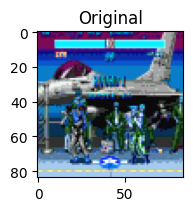

In [54]:
# Original image
plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(cv2.cvtColor(obs, cv2.COLOR_BGR2RGB))

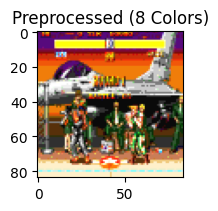

In [55]:
# Preprocessed image
plt.subplot(1, 3, 2)
plt.title('Preprocessed (8 Colors)')
plt.imshow(preprocessed)

In [56]:
# Color palette used
unique_colors = np.unique(preprocessed.reshape(-1, 3), axis=0)
color_display = np.zeros((100, len(unique_colors)*50, 3), dtype=np.uint8)
for i, color in enumerate(unique_colors):
    color_display[:, i*50:(i+1)*50] = color

(-0.5, 7149.5, 99.5, -0.5)

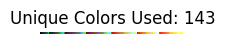

In [57]:
plt.subplot(1, 3, 3)
plt.title(f'Unique Colors Used: {len(unique_colors)}')
plt.imshow(color_display)
plt.axis('off')

In [58]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>